
При работе с данными в Python у программистов есть инструмент, который никогда не подведет: [pandas](https://pandas.pydata.org/). Это полнофункциональная и интуитивно понятная библиотека с открытым ПО, предоставляющая структуры данных для работы с высокоразмерными датасетами. 

Выделяют 2 основные структуры данных: 

-   `Series` для одномерных массивов; 
-   `DataFrame` для двухмерных таблиц, содержащих строки и столбцы. 

В статье мы рассмотрим наиболее эффективные функции для разделения датасетов на группы. После этого можно проводить статические вычисления, например находить стандартное отклонение, среднее, максимальное и минимальное значение, а также многое другое.

Вы научитесь применять функции `apply`, `cut`, `groupby` и `agg`. Они могут весьма пригодиться для лучшего понимания данных на основе их графического представления . 




## 1. Импорт данных 

Начнем с импорта библиотек и датасетов. В работе будем использовать датасет с ценами на недвижимость Бостона, доступный в библиотеке Scikit-learn. 


In [7]:
import numpy as np # линейная алгебра
import pandas as pd # обработка данных, CSV файл ввода-вывода (например, pd.read_csv)


In [22]:
df = pd.DataFrame(
    np.random.randint(1, 300, 6000),
    columns=['one']
)
df['two'] = df['one'] + np.random.randint(1, 300, 6000)

In [23]:
df

,one,two
0,174,463
1,252,510
2,297,305
3,25,123
4,184,208
...,...,...
5995,130,131
5996,30,176
5997,54,107
5998,85,278


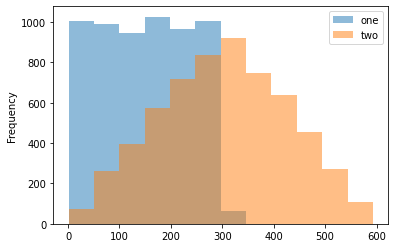

In [24]:
ax = df.plot.hist(bins=12, alpha=0.5)

In [ ]:
from sklearn import linear_model
# from sklearn.datasets import load_boston

In [ ]:

boston = load_boston()
df = pd.DataFrame(data=boston.data,columns=boston.feature_names)
df['price']=boston.target
df.head()



![](https://cdn-images-1.medium.com/max/533/0*Qvu99pmc-LIfhugf.png)

Данный `DataFrame` содержит только числовые признаки, а нам нужны категориальные переменные для разделения датасета на группы. Следовательно, займемся их созданием с помощью его описательной статистики: 

```
df.describe()
```

![](https://cdn-images-1.medium.com/max/533/0*UPdtWZs6gYnBGqdP.png)

Допустим, нам нужны категориальные признаки для RM (число комнат) и price (цены), которые представляют собой среднее число комнат на жилое помещение и медиану цен на жилье в размере $10,000 соответственно. В зависимости от диапазона значений указанных числовых признаков у этих переменных должны быть разные уровни (level), для создания которых задействуем значения первого и третьего квантиля. С целью генерирования этих новых переменных воспользуемся функцией `apply`.



In [ ]:

df['RM_levels']=df['RM'].apply(lambda x: 'low' if x<5.8 else 'middle' if x<6.6 else 'high')
df['price_levels']=df['price'].apply(lambda x: 'low' if x<17 else 'middle' if x<25 else 'high')
df[['RM','RM_levels','price','price_levels']].head()




![](https://cdn-images-1.medium.com/max/533/0*Mtfi-o9bNDMAdedA.png)

Новые столбцы появились благодаря функции `apply`, которая по умолчанию работает с каждой строкой датасета. Она по порядку проверяет условия. Первый уровень содержит значения числовых признаков, не превышающих первый квантиль. “Средний” уровень включает значения, располагающиеся в диапазоне между первым и третьим квантилем. Третий и последний уровень охватывают только значения, превосходящие третий квантиль. 

Функция `cut`  —  альтернативный и более эффективный способ создания таких переменных, в особенности тех, что обладают несколькими уровнями. Как и в предыдущем случае, делим значения price на 3 группы: ```
[3,5.8),[5.8,6.6),[6.6,9)
```, где 3 и 9 соответствуют минимальной и максимальной границам переменной. Эту же логику применяем и к числу комнат. Передав только интервальные значения и аргумент `right=False` для игнорирования правого максимума, получаем следующие группы:


In [ ]:

df['RM_levels'] = pd.cut(df['RM'],bins=[3,5.8,6.6,9],right=False)
df['price_levels'] = pd.cut(df['price'],bins=[5,17,25,51],right=False)
df[['RM','RM_levels','price','price_levels']].head()


![](https://cdn-images-1.medium.com/max/533/0*2S6HwkEOmP5Z1ohk.png)

При необходимости сохранить эти метки учитывайте тот факт, что несмотря на категориальный тип новых столбцов, **отдельные элементы являются не строками, а объектами** `**Interval**`! Попытка осуществить поиск конкретного класса значений `price` окажется безрезультатной. 



In [ ]:

df[df.price_levels=='[17, 25)']




![](https://cdn-images-1.medium.com/max/533/0*lgv624v_8Dpl4xms.png)

Если проверить тип столбца `price_levels`, взяв лишь первую строку, то увидим, что у нас есть на самом деле: 



In [ ]:

type(df['price_levels'][0])




![](https://cdn-images-1.medium.com/max/533/0*BKZwC1LiF3XbFsCt.png)

Если вы намерены сохранить эти интервалы, то во избежание сложностей подскажу один прием  —  передайте метку для каждой группы, установив аргумент `labels` со списком строк: 



In [ ]:
l=[[3,5.8,6.6,9],[5,17,25,51]]
lbs1 = ['[{},{})'.format(l[0][i],l[0][i+1]) for i in range(len(l[0])-1)]
lbs2 = ['[{},{})'.format(l[1][i],l[1][i+1]) for i in range(len(l[1])-1)]

df['RM_levels'] = pd.cut(df['RM'],bins=[3,5.8,6.6,9],right=False,labels=lbs1)
df['price_levels'] = pd.cut(df['price'],bins=[5,17,25,51],right=False,labels=lbs2)
print(type(df['price_levels'][0]))


```

![](https://cdn-images-1.medium.com/max/533/0*sN9SKA8zhQtiQ4Jg.png)

Теперь у вас есть строковые объекты! В любом случае в данной статье я буду сохранять метки, как показано ниже, всегда устанавливая аргумент `labels`: 




df['RM_levels'] = pd.cut(df['RM'],bins=[3,5.8,6.6,9],labels=['low','middle','high'],right=False)
df['price_levels'] = pd.cut(df['price'],bins=[5,17,25,51],labels=['low','middle','high'],right=False)




![](https://cdn-images-1.medium.com/max/533/0*rVxMvVLbjqIfYT3P.png)

## 2. Простые агрегации 

Итак, первый этап пройден, и мы приступаем к группировке датасета на основании заданных признаков. Допустим, нужно узнать среднее значение каждого столбца для каждого типа price:


df_price = df.groupby(by=['price_levels']).mean()
df_price


![](https://cdn-images-1.medium.com/max/533/0*i3kD8HYxtqFDcKme.png)

Как видно, по каждому уровню мы получили строку, содержащую соответствующие средние значения всех переменных, представленных в датасете. Переменная `price_levels` считается индексом, поскольку `groupby` по умолчанию в качестве такого индекса возвращает метку группы. Обратите внимание на произвольный порядок уровней. Выясним причину:



In [ ]:

df.info()




![](https://cdn-images-1.medium.com/max/533/0*29eA2ps-oTqeBEKi.png)

На данный момент новые переменные сохранены в памяти как объекты. Очевидно, что их необходимо преобразовать в категории. Как только мы это сделали, определяем порядок уровней переменных. 



In [ ]:

df['price_levels']=df['price_levels'].astype('category')
df['price_levels'].cat.reorder_categories(['low','middle','high'], inplace=True)

df['RM_levels']=df['RM_levels'].astype('category')
df['RM_levels'].cat.reorder_categories(['low','middle','high'], inplace=True)




Попробуем заново сгруппировать датасет для каждого уровня price. Если установить аргумент `as_index` в значение `False`, то метка группы более не будет рассматриваться в качестве индекса:

```


In [ ]:
df_price = df.groupby(by=['price_levels'],as_index=False).mean()
df_price


```

![](https://cdn-images-1.medium.com/max/533/0*02xwnHsVwKbVF7z2.png)

В результате получаем упорядоченные уровни и переменную `price_levels`, которая более не является индексом. Как видим, датасет содержит много столбцов. Их число можно сократить, если выбрать лишь несколько признаков (например, RM и price). Кроме того, расположим ценовые уровни по возрастанию.

```


In [ ]:
df_price = df.groupby(by=['price_levels'],as_index=False)[['price','RM']].mean().sort_values(by='price_levels', ascending=True)
df_price


```

![](https://cdn-images-1.medium.com/max/533/0*s8Pff93jZZORP-bH.png)

С увеличением числа комнат повышается стоимость жилплощади. Но что если мы не хотим ограничиваться вычислением среднего, минимального и максимального значений? В таком случае нам потребуется функция `apply`. Выясним диапазон значений столбцов CRIM и LSTAT, имена которых соответственно означают уровень преступности на душу населения по городу и процент граждан с низким социальным статусом.

```


In [ ]:
df_price = df.groupby(by=['price_levels'],as_index=False)[['CRIM','LSTAT']].apply(lambda v: v.max()-v.min())df_price


```

![](https://cdn-images-1.medium.com/max/533/0*u05_ZzlZ1hnNm3eA.png)

Как видно, уровень преступности и процент населения с низким социальным положением уменьшаются с ростом цен на жилплощадь. Представим это соотношение в виде гистограммы: 

```


In [ ]:
import plotly.express as px

fig = px.bar(df_price, x='price_levels', y='CRIM', labels={'price_levels':'Price','CRIM':'Range of Criminality'})
fig.show()


```

![](https://cdn-images-1.medium.com/max/533/0*R2lFfS7Lwt3UPwlG.png)

## 3. Множественные агрегации 

С целью выполнения множественных агрегаций для нескольких столбцов потребуется функция `agg`, позволяющая применить среднее, минимальное и максимальное значения, а также стандартное отклонение для каждого выбранного столбца. Результаты сгруппируем по типу цены.

```


In [ ]:
df_price = df.groupby(by=['price_levels'],as_index=False)[['price','AGE','CRIM']].agg(['mean','min','max','std'])
df_price


```

![](https://cdn-images-1.medium.com/max/533/0*SchKG9A5B2kFGo5D.png)

Как видно, при добавлении функции `agg` аргумент `as_index` более не работает. Во избежание использования метки группы в качестве индекса можно в конце поместить функцию `reset_index`:

```


In [ ]:
df_price = df.groupby(by=['price_levels'])[['price','AGE','CRIM']].agg(['mean','min','max','std']).reset_index()
df_price


```

![](https://cdn-images-1.medium.com/max/533/0*NwOJDGoBJKNaVNNU.png)

Теперь все признаки агрегированы, но при работе с этим датасетом могут возникнуть проблемы. Выбирая конкретный признак, вы должны указывать двойные индексы: 

```


In [ ]:
df_price.columns


```

![](https://cdn-images-1.medium.com/max/533/0*ead49TEvagUKUjf2.png)

Работа с двойными индексами может стать обременительной. Чтобы не создавать лишних сложностей, можно заменить имена столбцов следующим образом: 

```


In [ ]:
stats = ['mean','min','max','std']
df_price.columns = ['price_levels']+['price_{}'.format(stat) for stat in stats]+['age_{}'.format(stat) for stat in stats]+['age_{}'.format(stat) for stat in stats]
df_price


```

![](https://cdn-images-1.medium.com/max/533/0*2vECzgp5fubHFGn5.png)

С таким `DataFrame` работается уже намного легче. 

Передача словаря в функцию `agg` позволит применять различные статистики в зависимости от столбца. В этом случае ключами будут имена столбцов, а значениями  —  агрегированная функция, подлежащая измерению. На этот раз для группировки датасета нам понадобятся два признака: 

```


In [ ]:
df_price = df.groupby(by=['price_levels','RM_levels'],as_index=False).agg({'CRIM':['count','mean','max','min'],'price':['mean']})
df_price


```

![](https://cdn-images-1.medium.com/max/533/0*6pjUUg0IHGpzj3Fj.png)

Отразим новые итоги обработки данных в гистограмме. Сначала поменяем метки датасета, а затем посмотрим на результаты для жилья с наибольшим числом комнат. 

```


In [ ]:
import plotly.express as px

stats = ['count','mean','max','min']
df_price.columns = ['price_levels','RM_levels']+['CRIM_{}'.format(stat) for stat in stats]+['price_mean']
df_price
fig = px.bar(df_price[df_price.RM_levels=='high'], x='price_levels', y='CRIM_count', labels={'price_levels':'Price','CRIM_count':'Count of observations'})
fig.show()



![](https://cdn-images-1.medium.com/max/533/0*WBh7J0Diqf19R-b6.png)

Очевидно, что число домов увеличивается с ростом цены, поскольку мы выбрали большое количество комнат. Налицо прямая зависимость между числом комнат и ценой дома.